#### Install Google Cloud Dependencies

In [ ]:
!pip install google-cloud-bigquery > /dev/null

In [ ]:
from google.cloud import bigquery
from google.cloud import storage
from google.colab import auth
import pandas as pd ; pd.set_option('display.max_columns', 500)
import numpy as np
import io

#### Authentificate Colab with my Google account

In [ ]:
auth.authenticate_user()

#### Add Google Cloud Configurations

To begin this project, I first familiarized myself with the Google Cloud Platform (GCP) ecosystem. This involved creating my own GCP account and getting to know its core services. Here's a straightforward breakdown of the main GCP services I used:

- **Google Cloud Storage (GCS):** This is where I stored the raw CSV data.
- **Google BigQuery (BQ):** I used it to keep the prepared tables, ready for analysis.
- **Looker Studio:** It helped me create interactive dashboards for reporting purposes.

In [ ]:
# Configuration parameters
project_id = 'matchtennis'
bucket_name = 'matchtennis'

Then, i created a Project named **`matchtennis`** and a **`matchtennis`** bucket in GCS.

<div align="center">
  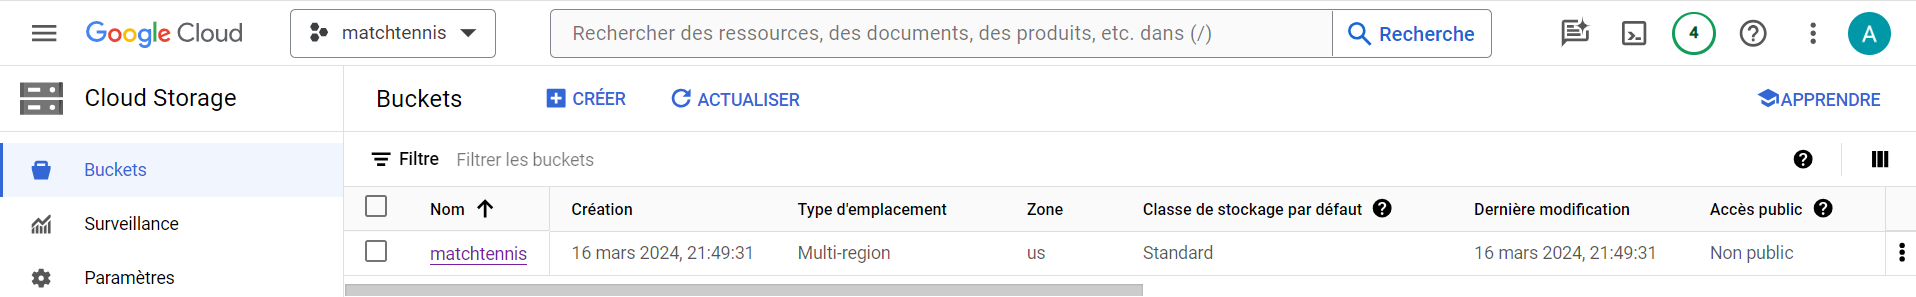
</div>

In [ ]:
# Initialize clients for BigQuery and Google Cloud Storage
bq_client = bigquery.Client(project=project_id)
gcs_client = storage.Client(project=project_id)

#### Data Modeling
Here is how I propose to model the Original data:

- **Fact Table (MatchBets)**: Stores quantitative betting data.
  - Contains odds (`home_odd`, `away_odd`), match status (`has_started`), and links to the Matches dimension via `kindred_id`.

- **Dimension Table (Matches)**: Describes match attributes.
  - Holds match identifiers (`kindred_id`), bet offer types, and data extraction timestamps.

<div align="center">
  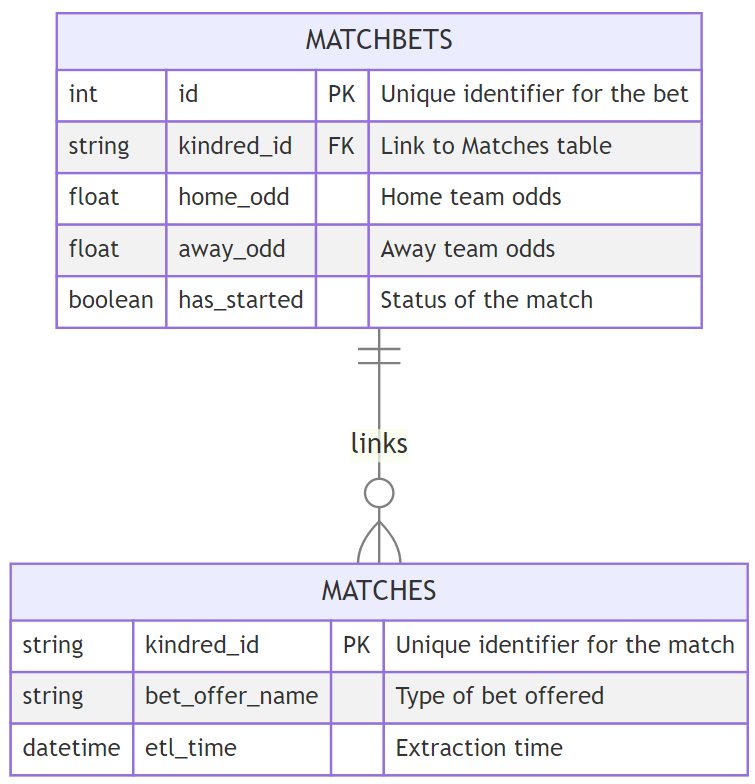
</div>


In [ ]:
# Load the original CSV file
matchtennis_df = pd.read_csv('/content/matchtennis.csv')

# Create the Matches dimension table
matches_dimension = matchtennis_df[['kindred_id', 'bet_offer_name', 'etl_time']].drop_duplicates()

# Create the MatchBets fact table
match_bets_fact = matchtennis_df[['id', 'kindred_id', 'home_odd', 'away_odd', 'has_started']]

# Save the Dfs
matches_dimension.to_csv('matches_dimension.csv', index=False)
match_bets_fact.to_csv('match_bets_fact.csv', index=False)

In [ ]:
matchtennis_df.head(1)

,id,kindred_id,bet_offer_name,has_started,home_odd,away_odd,etl_time
0,245,1008114274,Match Odds,False,1.78,2.0,2021-09-30 10:01:00 UTC


In [ ]:
matches_dimension.head(1)

,kindred_id,bet_offer_name,etl_time
0,1008114274,Match Odds,2021-09-30 10:01:00 UTC


In [ ]:
match_bets_fact.head(1)

,id,kindred_id,home_odd,away_odd,has_started
0,245,1008114274,1.78,2.0,False


#### Pre-Load: Step 0 - Data Preparation
The idea here is to load the CSV files from Google Colab to Google Cloud Storage. The files are `match_bets_fact.csv` and `matches_dimension.csv`. These files will be later ingested into the ETL Pipeline.

In [ ]:
# Specify the destination file names in GCS
file_names = ['match_bets_fact.csv', 'matches_dimension.csv']

# Specify the file paths for saving locally before upload
local_paths = ['/content/match_bets_fact.csv',
               '/content/matches_dimension.csv']

# DataFrames to upload
dfs = [match_bets_fact, matches_dimension]

# Save DataFrames to CSV and upload
for df, local_path, file_name in zip(dfs, local_paths, file_names):
    # Save the DataFrame to a CSV file
    df.to_csv(local_path, index=False)

    # Get the bucket
    bucket = gcs_client.bucket(bucket_name)

    # Create a blob object from the filename
    blob = bucket.blob(file_name)

    # Upload the file to GCS
    blob.upload_from_filename(local_path)

    print(f"File {file_name} uploaded to {bucket_name}.")

File match_bets_fact.csv uploaded to matchtennis.
File matches_dimension.csv uploaded to matchtennis.


<div align="center">
  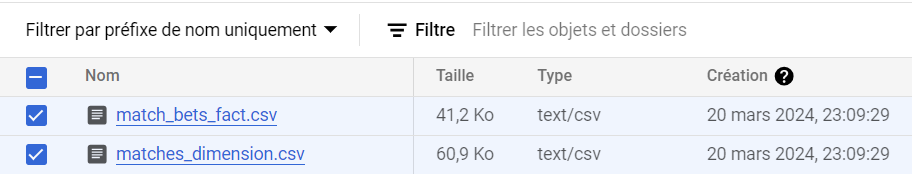
</div>

## ETL Pipeline
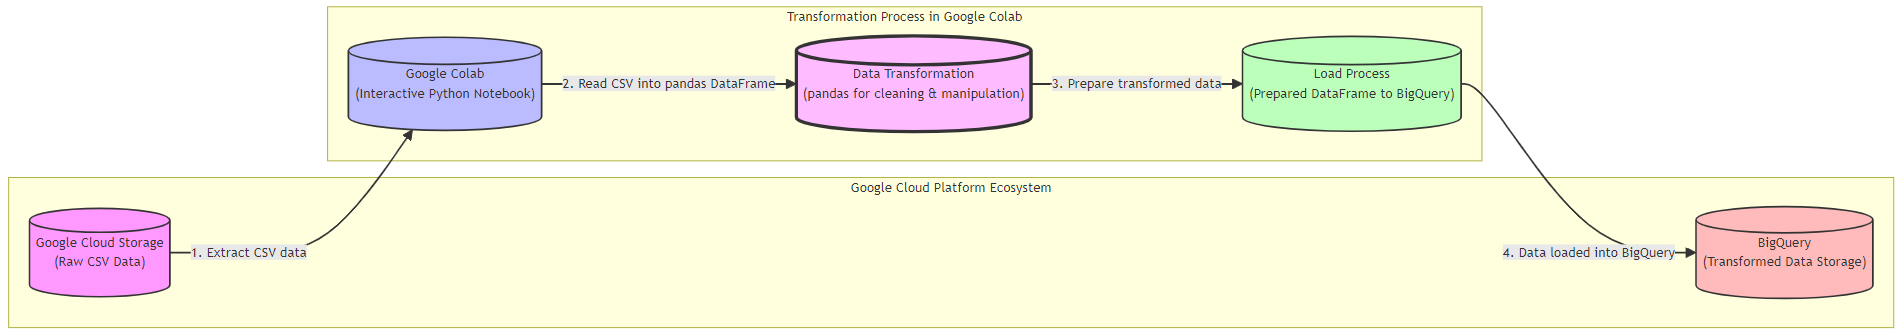

###### 1. Extraction
- **Source:** Google Cloud Storage (GCS)
- I extracted the raw CSV files to begin processing them.

###### 2. Transformation
- **Tool:** Google Colab
- Using pandas DataFrames, I cleaned and manipulated the data to make sure it was ready for analysis.

###### 3. Loading
- **Destination:** BigQuery
- The transformed data was stored in BigQuery, ready for in-depth analysis and querying.

#### Input of the ETL Pipeline
The input to the ETL Pipeline will be the two files that we uploaded to the GCS bucket.

In [ ]:
# Set the GCS path to the CSV files
csv_path_fact_table = f"gs://{bucket_name}/{file_names[0]}"
csv_path_dim_table = f"gs://{bucket_name}/{file_names[1]}"

print("CSV Fact Table Path:", csv_path_fact_table)
print("CSV Dimension Table Path:", csv_path_dim_table)

CSV Fact Table Path: gs://matchtennis/match_bets_fact.csv
CSV Dimension Table Path: gs://matchtennis/matches_dimension.csv


#### Output of the ETL Pipeline

At the end of the ETL Pipeline, the transformed data will be saved in a table in BigQuery. Let's define its name.

In [ ]:
# Full path of the destination table in BigQuery
output_table_ref = "matchtennis.match_tennis.transformed_match_table"

#### Extaction : Step 1 of the ETL

In [ ]:
# Extract the CSV Fact data from GCS into a pandas DataFrame
bucket = gcs_client.bucket(bucket_name)
blob_fact = bucket.blob(file_names[0])
bytes_data_fact = blob_fact.download_as_bytes()
fact_csv_data = io.BytesIO(bytes_data_fact)
fact_df = pd.read_csv(fact_csv_data)
fact_df.head(2)

,id,kindred_id,home_odd,away_odd,has_started
0,245,1008114274,1.78,2.0,False
1,56,1008085582,1.74,2.0,False


In [ ]:
# Extract the CSV Dimension data from GCS into a pandas DataFrame
bucket = gcs_client.bucket(bucket_name)
blob_dim = bucket.blob(file_names[1])
bytes_data_dim = blob_dim.download_as_bytes()
dim_csv_data = io.BytesIO(bytes_data_dim)
dim_df = pd.read_csv(dim_csv_data)
dim_df.head(2)

,kindred_id,bet_offer_name,etl_time
0,1008114274,Match Odds,2021-09-30 10:01:00 UTC
1,1008085582,Match Odds,2021-09-20 10:01:00 UTC


#### Transformation: Step 2 of the ETL Pipeline

The first task is to merge the files into one file so that we can apply the transformation. Eventually, we'll upload the transformed data to BigQuery.

In [ ]:
df_merged = pd.merge(fact_df,
                     dim_df,
                     on='kindred_id',
                     how='left')
df_merged.head(4)

,id,kindred_id,home_odd,away_odd,has_started,bet_offer_name,etl_time
0,245,1008114274,1.78,2.0,False,Match Odds,2021-09-30 10:01:00 UTC
1,245,1008114274,1.78,2.0,False,Match Odds,2021-09-30 16:01:00 UTC
2,245,1008114274,1.78,2.0,False,Match Odds,2021-09-30 13:01:00 UTC
3,56,1008085582,1.74,2.0,False,Match Odds,2021-09-20 10:01:00 UTC


Now, let's apply data transformation on the merged data

In [ ]:
def transform_data(df):
    # Convert etl_time to datetime and ensure it's in UTC
    df['etl_time'] = pd.to_datetime(df['etl_time'], utc=True)

    # Initial time series metrics
    df['hour_of_day'] = df['etl_time'].dt.hour
    df['day_of_week'] = df['etl_time'].dt.dayofweek
    df['week_of_year'] = df['etl_time'].dt.isocalendar().week
    df['month'] = df['etl_time'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Odds analysis metrics
    df['odds_ratio'] = df['home_odd'] / df['away_odd']
    df['odds_diff'] = df['home_odd'] - df['away_odd']

    # Normalization of odds (min-max scaling)
    df['home_odd_normalized'] = (df['home_odd'] - df['home_odd'].min()) / (df['home_odd'].max() - df['home_odd'].min())
    df['away_odd_normalized'] = (df['away_odd'] - df['away_odd'].min()) / (df['away_odd'].max() - df['away_odd'].min())

    # Time until start (assuming etl_time is the event start time for demonstration)
    current_time_utc = pd.Timestamp.now(tz='UTC')
    df['time_until_start'] = (df['etl_time'] - current_time_utc).dt.total_seconds() / (60 * 60)

    # Log transformation of odds
    df['log_home_odd'] = np.log(df['home_odd'])
    df['log_away_odd'] = np.log(df['away_odd'])

    # Encoding of bet_offer_name
    df['bet_offer_type'] = df['bet_offer_name'].factorize()[0]

    # Additional transformations
    df['inverse_home_odd'] = 1 / df['home_odd']
    df['inverse_away_odd'] = 1 / df['away_odd']
    df['odds_sum'] = df['home_odd'] + df['away_odd']

    # Categorical Encoding for Time of Day
    conditions = [
        (df['hour_of_day'] < 6),
        (df['hour_of_day'] < 12),
        (df['hour_of_day'] < 18),
        (df['hour_of_day'] <= 23)
    ]
    values = ['Night', 'Morning', 'Afternoon', 'Evening']
    df['time_of_day'] = np.select(conditions, values)

    # Other transformations
    df['normalized_time_until_start'] = (df['time_until_start'] - df['time_until_start'].mean()) / df['time_until_start'].std()
    df['match_importance_index'] = (df['home_odd_normalized'] + df['away_odd_normalized']) * df['month'] / 12
    df['evening_prime_time'] = df['hour_of_day'].apply(lambda x: 1 if 18 <= x <= 21 else 0)
    df['odds_volatility_score'] = ((df['home_odd'] / df['away_odd']) - 1).abs() * df['week_of_year'] / 52
    df['odds_interaction'] = df['home_odd'] * df['away_odd']

    return df

df_transformed = transform_data(df_merged)
df_transformed.head(2)

,id,kindred_id,home_odd,away_odd,has_started,bet_offer_name,etl_time,hour_of_day,day_of_week,week_of_year,month,is_weekend,odds_ratio,odds_diff,home_odd_normalized,away_odd_normalized,time_until_start,log_home_odd,log_away_odd,bet_offer_type,inverse_home_odd,inverse_away_odd,odds_sum,time_of_day,normalized_time_until_start,match_importance_index,evening_prime_time,odds_volatility_score,odds_interaction
0,245,1008114274,1.78,2.0,False,Match Odds,2021-09-30 10:01:00+00:00,10,3,39,9,0,0.89,-0.22,0.038519,0.049525,-21698.030494,0.576613,0.693147,0,0.561798,0.5,3.78,Morning,-1.182206,0.066033,0,0.0825,3.56
1,245,1008114274,1.78,2.0,False,Match Odds,2021-09-30 16:01:00+00:00,16,3,39,9,0,0.89,-0.22,0.038519,0.049525,-21692.030494,0.576613,0.693147,0,0.561798,0.5,3.78,Afternoon,-1.126602,0.066033,0,0.0825,3.56


#### Load : Step 3 of the ETL Pipeline (Load the transformed data into BigQuery)

<div align="center">
  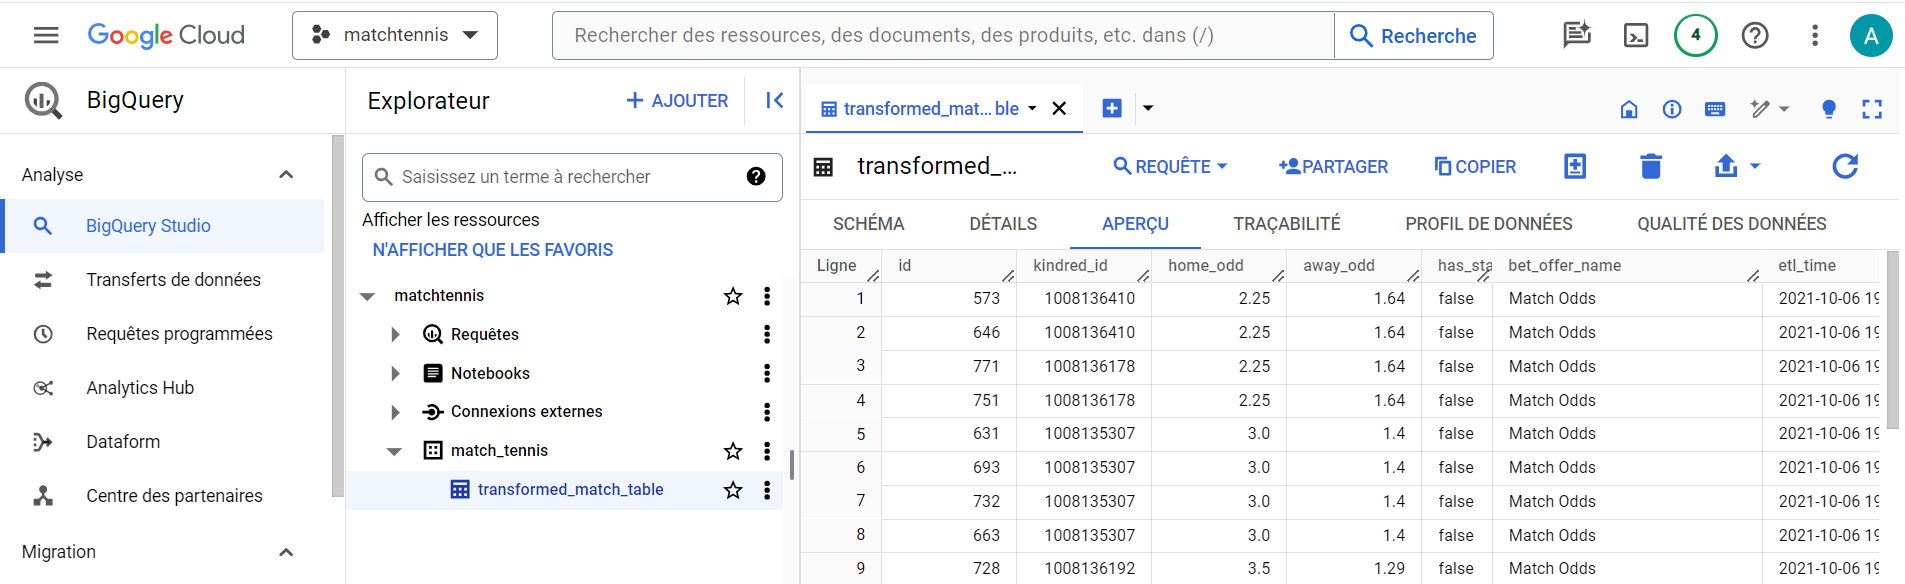
</div>

In [ ]:
transformed_csv = io.StringIO() # Convert the DataFrame to a CSV in memory
df_transformed.to_csv(transformed_csv, index=False)
transformed_csv.seek(0)

# Define the job configuration for the BigQuery load job
job_config = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.CSV,
    skip_leading_rows=1,
    autodetect=True,  # Automatically detect the schema of the CSV
    write_disposition='WRITE_TRUNCATE',  # Overwrites the table if it exists
)

# Load the transformed data into BigQuery
load_job = bq_client.load_table_from_file(
    file_obj=transformed_csv,
    destination=output_table_ref,
    job_config=job_config
)

# Wait for the job to finish
load_job.result()

# Confirmation message
print("Data has been transformed and loaded into BigQuery successfully.")

Data has been transformed and loaded into BigQuery successfully.


#### Check the Uploaded Table Schema

In [ ]:
# Verify the schema of the new table (optional)
output_table = bq_client.get_table(output_table_ref)
print("Schema of the transformed table:")
for schema_field in output_table.schema:
    print(schema_field)

Schema of the transformed table:
SchemaField('id', 'INTEGER', 'NULLABLE', None, None, (), None)
SchemaField('kindred_id', 'INTEGER', 'NULLABLE', None, None, (), None)
SchemaField('home_odd', 'FLOAT', 'NULLABLE', None, None, (), None)
SchemaField('away_odd', 'FLOAT', 'NULLABLE', None, None, (), None)
SchemaField('has_started', 'BOOLEAN', 'NULLABLE', None, None, (), None)
SchemaField('bet_offer_name', 'STRING', 'NULLABLE', None, None, (), None)
SchemaField('etl_time', 'TIMESTAMP', 'NULLABLE', None, None, (), None)
SchemaField('hour_of_day', 'INTEGER', 'NULLABLE', None, None, (), None)
SchemaField('day_of_week', 'INTEGER', 'NULLABLE', None, None, (), None)
SchemaField('week_of_year', 'INTEGER', 'NULLABLE', None, None, (), None)
SchemaField('month', 'INTEGER', 'NULLABLE', None, None, (), None)
SchemaField('is_weekend', 'INTEGER', 'NULLABLE', None, None, (), None)
SchemaField('odds_ratio', 'FLOAT', 'NULLABLE', None, None, (), None)
SchemaField('odds_diff', 'FLOAT', 'NULLABLE', None, None, (

## Data Viz in Looker Studio

At the end, i linked the transformed data in BigQuery to a Looker studio Dashboard, and here is how it looks like
<div align="center">
  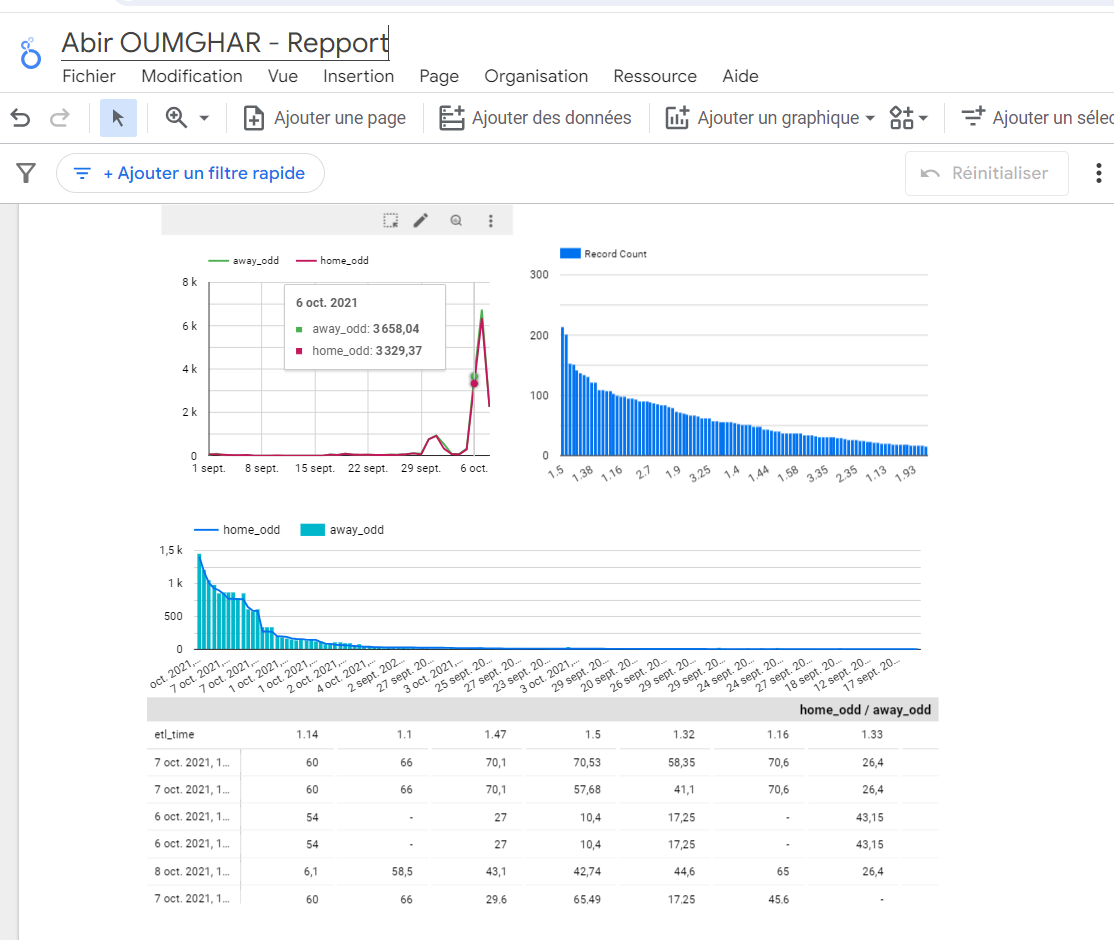
</div>